# U-Net Model Training for Fault Segmentation (PyTorch)

## Step 1: Import Libraries

"First, we import all the necessary libraries. This includes standard libraries like `os` and `numpy`, deep learning libraries from `tensorflow.keras`, and the custom modules `DataGenerator` and `unet` from our project.

In [1]:
import os
import shutil
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

# Project‑local code
from utils_pytorch import DataGenerator
from unet3_pytorch import unet, cross_entropy_balanced

2025-07-31 20:41:59.314588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753987319.337558  317250 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753987319.344561  317250 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753987319.363975  317250 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753987319.364007  317250 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753987319.364008  317250 computation_placer.cc:177] computation placer alr

In [2]:
try:
    ROOT_DIR = os.path.dirname(os.path.abspath(__file__))  # for .py scripts
except NameError:
    ROOT_DIR = os.getcwd()  # for Jupyter notebooks

## Step 1a: Verify GPU Availability
This cell checks if TensorFlow can detect a GPU. If a GPU is available, it enables memory growth to prevent TensorFlow from allocating all of the GPU's memory at once.

In [3]:
# Check whether CUDA is available and configure deterministic behaviour.
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU detected -> using {torch.cuda.get_device_name(0)}")
    # (Optional) set cudnn benchmark / deterministic flags according to your needs
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
    print("No GPU detected.  Running on CPU.")

GPU detected -> using NVIDIA RTX A5000


## Step 2: Define Paths and Parameters

In [4]:
base_dir = os.path.abspath(os.path.join(ROOT_DIR, "..", "data", "data_from_Wu"))
train_seis_dir = os.path.join(base_dir, "train/seis")
train_fault_dir = os.path.join(base_dir, "train/fault")
validation_seis_dir = os.path.join(base_dir, "validation/seis")
validation_fault_dir = os.path.join(base_dir, "validation/fault")
prediction_seis_dir = os.path.join(base_dir, "prediction/f3d")

# --- Output: Processed .npy directories ---
processed_data_dir = os.path.join(ROOT_DIR, "data")
train_dir_new = os.path.join(processed_data_dir, 'train_npy')
validation_dir_new = os.path.join(processed_data_dir, 'validation_npy')
prediction_dir_new = os.path.join(processed_data_dir, 'prediction_npy')

# --- Model/Log dirs (unchanged) ---
model_dir = os.path.join(ROOT_DIR, "model")
log_dir = os.path.join(ROOT_DIR, "output", "logs")
checkpoint_dir = os.path.join(ROOT_DIR, "output", "checkpoints")

In [ ]:
# --- Training Parameters ---
params = {
    'batch_size' : 1,          # effective batch (original + flipped)
    'dim'        : (128,128,128),
    'n_channels' : 1,
    'shuffle'    : True
}

In [8]:
epochs         = 25
learning_rate  = 1e-4

## Step 3: Prepare Data

This step involves converting the original `.dat` files into the `.npy` format that our `DataGenerator` expects. We also split the data into training and validation sets. This is a crucial preprocessing step.

In [9]:
def convert_dat_to_npy():
    """
    Read every *.dat* volume, reshape to (128,128,128) and save it as a
    proper *.npy* file.  The new files include the NumPy header, so they
    can be loaded with np.load() (the allow_pickle issue disappears).
    """
    # ------------------------------------------------------------------
    # 1) start from a clean processed-data directory
    # ------------------------------------------------------------------
    if os.path.exists(processed_data_dir):
        shutil.rmtree(processed_data_dir)
        print(f"Removed old processed data directory: {processed_data_dir}")

    for path in [
        os.path.join(train_dir_new, 'seis'),
        os.path.join(train_dir_new, 'fault'),
        os.path.join(validation_dir_new, 'seis'),
        os.path.join(validation_dir_new, 'fault'),
        model_dir, log_dir, checkpoint_dir
    ]:
        os.makedirs(path, exist_ok=True)

    # ------------------------------------------------------------------
    # 2) helper that does the actual conversion
    # ------------------------------------------------------------------
    def process_files(file_list, src_seis, src_fault, dst_root):
        for fname in file_list:
            # --- seismic cube ------------------------------------------------
            seis = np.fromfile(os.path.join(src_seis,  fname),
                               dtype=np.single).reshape(params['dim'])
            np.save(os.path.join(dst_root, 'seis',
                                 fname.replace('.dat', '.npy')), seis)

            # --- fault labels -----------------------------------------------
            fault = np.fromfile(os.path.join(src_fault, fname),
                                dtype=np.single).reshape(params['dim'])
            np.save(os.path.join(dst_root, 'fault',
                                 fname.replace('.dat', '.npy')), fault)
        print(f"Processed {len(file_list):>4} files  ->  {dst_root}")

    # ------------------------------------------------------------------
    # 3) run conversion for train / validation splits
    # ------------------------------------------------------------------
    train_files = [f for f in os.listdir(train_seis_dir) if f.endswith('.dat')]
    val_files   = [f for f in os.listdir(validation_seis_dir) if f.endswith('.dat')]

    process_files(train_files, train_seis_dir,      train_fault_dir,      train_dir_new)
    process_files(val_files,   validation_seis_dir, validation_fault_dir, validation_dir_new)

# --------------------------------------------------------------------------
# call it once
# --------------------------------------------------------------------------
convert_dat_to_npy()


Removed old processed data directory: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_2019_pyTorch/data
Processed  200 files  ->  /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_2019_pyTorch/data/train_npy
Processed   20 files  ->  /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_2019_pyTorch/data/validation_npy


## Step 4: Create Data Generators

Now that our data is in the correct format and location, we can use the `DataGenerator` from `utils.py` to feed it to our model efficiently. We create one generator for the training set and one for the validation set.

In [10]:
# Build PyTorch datasets & loaders
train_ID = [os.path.splitext(f)[0] for f in os.listdir(os.path.join(train_dir_new, "seis"))]
valid_ID = [os.path.splitext(f)[0] for f in os.listdir(os.path.join(validation_dir_new, "seis"))]

train_dataset = DataGenerator(dpath=os.path.join(train_dir_new, 'seis/'),
                              fpath=os.path.join(train_dir_new, 'fault/'),
                              data_IDs=train_ID,
                              dim=params['dim'])
valid_dataset = DataGenerator(dpath=os.path.join(validation_dir_new, 'seis/'),
                              fpath=os.path.join(validation_dir_new, 'fault/'),
                              data_IDs=valid_ID,
                              dim=params['dim'])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=params['shuffle'], num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False,             num_workers=4)

print("Number of training pairs :", len(train_ID))
print("Number of validation pairs:", len(valid_ID))


Number of training pairs : 200
Number of validation pairs: 20


## Step 5: Build and Compile the Model

We will now use the `unet` function from `unet3.py` to build our model architecture. After building it, we compile it with an optimizer, a loss function, and metrics to monitor.

In [11]:
model = unet().to(device)
optimiser = optim.Adam(model.parameters(), lr=learning_rate)
criterion = cross_entropy_balanced

print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")


Model has 1,459,585 trainable parameters


In [12]:
# Torch equivalent of callbacks
writer = SummaryWriter(log_dir)
os.makedirs(checkpoint_dir, exist_ok=True)

def save_ckpt(epoch):
    fname = os.path.join(checkpoint_dir, f"fseg-{epoch:02d}.pth")
    torch.save(model.state_dict(), fname)


## Step 6: Train the Model

With everything set up, we can now start training the model using the `fit` method. The training and validation data will be provided through our generators.

In [13]:
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(1, epochs + 1):
    # ---- training ----
    model.train()
    epoch_loss, epoch_acc = 0.0, 0.0
    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        optimiser.zero_grad()
        preds = model(X)
        loss  = criterion(preds, Y)
        loss.backward()
        optimiser.step()

        epoch_loss += loss.item()
        epoch_acc  += (preds.round() == Y).float().mean().item()

    epoch_loss /= len(train_loader)
    epoch_acc  /= len(train_loader)
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)
    writer.add_scalar('Loss/train',  epoch_loss, epoch)
    writer.add_scalar('Acc/train',   epoch_acc,  epoch)

    # ---- validation ----
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for X, Y in valid_loader:
            X, Y = X.to(device), Y.to(device)
            preds = model(X)
            loss  = criterion(preds, Y)
            val_loss += loss.item()
            val_acc  += (preds.round() == Y).float().mean().item()

    val_loss /= len(valid_loader)
    val_acc  /= len(valid_loader)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    writer.add_scalar('Loss/val',  val_loss, epoch)
    writer.add_scalar('Acc/val',   val_acc,  epoch)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"loss {epoch_loss:.4f} – acc {epoch_acc:.4f} | "
          f"val_loss {val_loss:.4f} – val_acc {val_acc:.4f}")

    save_ckpt(epoch)

writer.close()


Epoch 01/25 | loss 0.0719 – acc 0.7183 | val_loss 0.0555 – val_acc 0.8687
Epoch 02/25 | loss 0.0509 – acc 0.8229 | val_loss 0.0425 – val_acc 0.8635
Epoch 03/25 | loss 0.0426 – acc 0.8550 | val_loss 0.0372 – val_acc 0.8775
Epoch 04/25 | loss 0.0361 – acc 0.8802 | val_loss 0.0341 – val_acc 0.8867
Epoch 05/25 | loss 0.0320 – acc 0.8969 | val_loss 0.0311 – val_acc 0.8869
Epoch 06/25 | loss 0.0287 – acc 0.9074 | val_loss 0.0279 – val_acc 0.9039
Epoch 07/25 | loss 0.0262 – acc 0.9154 | val_loss 0.0283 – val_acc 0.8979
Epoch 08/25 | loss 0.0246 – acc 0.9197 | val_loss 0.0257 – val_acc 0.9246
Epoch 09/25 | loss 0.0230 – acc 0.9243 | val_loss 0.0264 – val_acc 0.9331
Epoch 10/25 | loss 0.0218 – acc 0.9272 | val_loss 0.0250 – val_acc 0.9107
Epoch 11/25 | loss 0.0210 – acc 0.9284 | val_loss 0.0236 – val_acc 0.9234
Epoch 12/25 | loss 0.0204 – acc 0.9303 | val_loss 0.0233 – val_acc 0.9336
Epoch 13/25 | loss 0.0188 – acc 0.9342 | val_loss 0.0227 – val_acc 0.9267
Epoch 14/25 | loss 0.0180 – acc 0.9358

## Step 7: Save the Final Model

After training is complete, we save the final model to the `model` directory for future use.

In [16]:
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_name = f"unet_pytorch_model_{len(train_ID)}pairs_{epochs}epochs_{now}.pth"
model_path = os.path.join(model_dir, model_name)
torch.save(model.state_dict(), model_path)
print(f"Final model saved to: {model_path}")

Final model saved to: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_2019_pyTorch/model/unet_pytorch_model_200pairs_25epochs_2025-07-31_21-06-01.pth


## Step 8: Visualize Training History

Finally, we visualize the training and validation accuracy and loss over the epochs. This helps us understand how well the model has learned.

In [17]:
def show_history(hist, save_path=None):
    print("Plotting training history...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    ax1.plot(hist['accuracy'],     label='Training Accuracy', color='b', marker='o')
    ax1.plot(hist['val_accuracy'], label='Validation Accuracy', color='r', marker='o', linestyle='--')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right', fontsize=12)
    ax1.grid(True)

    ax2.plot(hist['loss'],     label='Training Loss', color='b', marker='o')
    ax2.plot(hist['val_loss'], label='Validation Loss', color='r', marker='o', linestyle='--')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right', fontsize=12)
    ax2.grid(True)

    plt.tight_layout()
    plt.suptitle('PyTorch Model', fontsize = 18, y = 1.02)
    if save_path:
        plt.savefig(save_path)
        print(f"History plot saved to: {save_path}")
    plt.show()


Plotting training history...
History plot saved to: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_2019_pyTorch/output/history_plots/unet_pytorch_model_200pairs_25epochs_2025-07-31_21-06-01_history.png


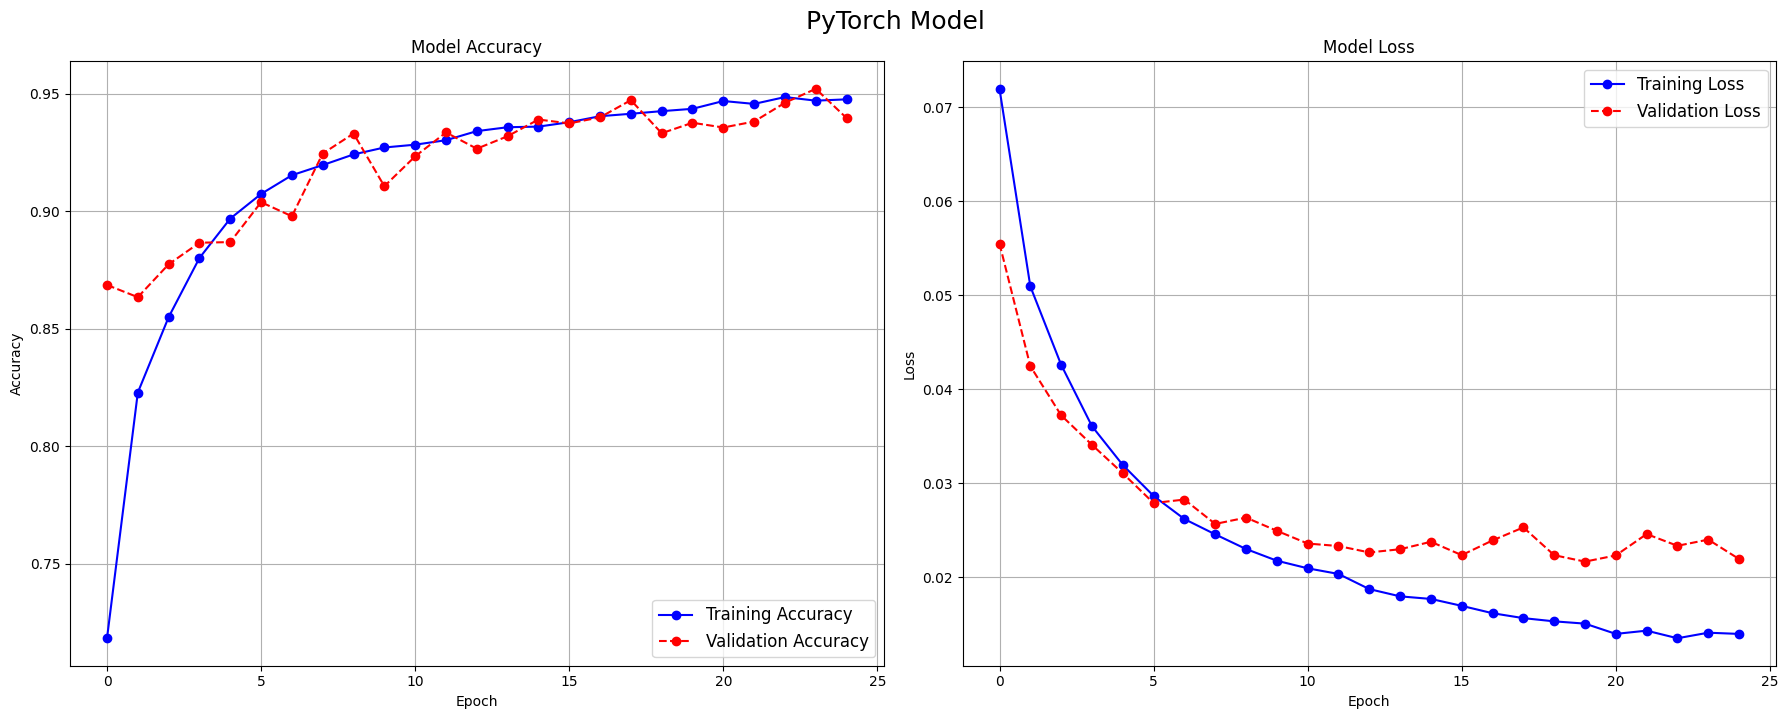

In [18]:
# 1) Build an output folder like “…/output/history_plots”
history_plot_dir = os.path.join(ROOT_DIR, "output", "history_plots")
os.makedirs(history_plot_dir, exist_ok=True)               # create if missing

# 2) Re-use the model filename to generate a matching plot name
base_name, _ = os.path.splitext(model_name)                # remove .pth
plot_name    = f"{base_name}_history.png"                  # e.g. …_history.png
plot_path    = os.path.join(history_plot_dir, plot_name)   # full absolute path

# 3) Draw & save
show_history(history, save_path=plot_path)